In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import textwrap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style
plt.style.use('default')
sns.set_palette("husl")

### Load dataframe

In [42]:
df = pd.read_csv('task_surgery_classification/out/1_refinement_output.csv')

In [43]:
def clean_auto_annot_labels(df, init_class_col, refined_class_col):
    # change any labels thats longer than 10 words to 'length error'
    df[refined_class_col] = df[refined_class_col].apply(
        lambda x: 'string termination error' if len(x.split()) > 10 else x
    )
    
    df[init_class_col] = df[init_class_col].apply(
        lambda x: 'string termination error' if len(x.split()) > 10 else x
    )
    return df

In [44]:
df = clean_auto_annot_labels(
    df, 
    init_class_col='INITIAL_CLASSIFICATION_RESULT', refined_class_col='REFINEMENT_RESULT'
)

### Classification distribution

In [ ]:
import textwrap

def plot_classification_distributions(df, init_class_col, refined_class_col, truncate_text=50):
    """Plot initial vs refined classification distributions with text wrapping"""
    
    def truncate_and_wrap(text, max_length=truncate_text, wrap_width=20):
        """Truncate text and wrap for better display"""
        if pd.isna(text):
            return "Unknown"
        
        # Convert to string and truncate
        text_str = str(text)
        if len(text_str) > max_length:
            text_str = text_str[:max_length] + "..."
        
        # Wrap text for better display
        wrapped = textwrap.fill(text_str, width=wrap_width)
        return wrapped
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Clean data and handle long text
    initial_counts = df[init_class_col].value_counts()
    refined_counts = df[refined_class_col].value_counts()
    
    # Initial classification distribution
    initial_labels = [truncate_and_wrap(label) for label in initial_counts.index]
    wedges, texts, autotexts = axes[0,0].pie(
        initial_counts.values, 
        labels=initial_labels, 
        autopct='%1.1f%%',
        textprops={'fontsize': 8}
    )
    # Adjust autotext size
    for autotext in autotexts:
        autotext.set_fontsize(8)
    axes[0,0].set_title('Initial Classification Distribution', fontsize=12, pad=20)
    
    # Refined classification distribution
    refined_labels = [truncate_and_wrap(label) for label in refined_counts.index]
    wedges, texts, autotexts = axes[0,1].pie(
        refined_counts.values, 
        labels=refined_labels, 
        autopct='%1.1f%%',
        textprops={'fontsize': 8}
    )
    # Adjust autotext size
    for autotext in autotexts:
        autotext.set_fontsize(8)
    axes[0,1].set_title('Refined Classification Distribution', fontsize=12, pad=20)
    
    # Side-by-side bar comparison
    comparison_df = pd.DataFrame({
        'Initial': initial_counts,
        'Refined': refined_counts
    }).fillna(0)
    
    # Truncate index labels for bar plot
    comparison_df.index = [truncate_and_wrap(label, max_length=truncate_text, wrap_width=15) 
                          for label in comparison_df.index]
    
    comparison_df.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Initial vs Refined Classification Counts', fontsize=12)
    axes[1,0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[1,0].legend(fontsize=10)
    
    # Changes visualization
    df_clean = df.copy()
    # Handle potential NaN values
    df_clean[init_class_col] = df_clean[init_class_col].fillna("Unknown")
    df_clean[refined_class_col] = df_clean[refined_class_col].fillna("Unknown")
    
    df_clean['changed'] = df_clean[init_class_col] != df_clean[refined_class_col]
    change_counts = df_clean['changed'].value_counts()
    
    # Map boolean values to readable labels
    change_labels = ['No Change' if not changed else 'Changed' for changed in change_counts.index]
    
    axes[1,1].pie(change_counts.values, 
                  labels=change_labels, 
                  autopct='%1.1f%%',
                  colors=['lightblue', 'orange'],
                  textprops={'fontsize': 10})
    axes[1,1].set_title('Classification Changes', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('task_surgery_classification/classification_distributions.png', dpi=300)

    plt.show()    
    
    # Print summary statistics
    print(f"\n📊 CLASSIFICATION SUMMARY:")
    print(f"Total procedures: {len(df):,}")
    print(f"Changed classifications: {sum(df_clean['changed']):,} ({sum(df_clean['changed'])/len(df)*100:.1f}%)")
    print(f"Initial classes: {df[init_class_col].nunique()}")
    print(f"Refined classes: {df[refined_class_col].nunique()}")

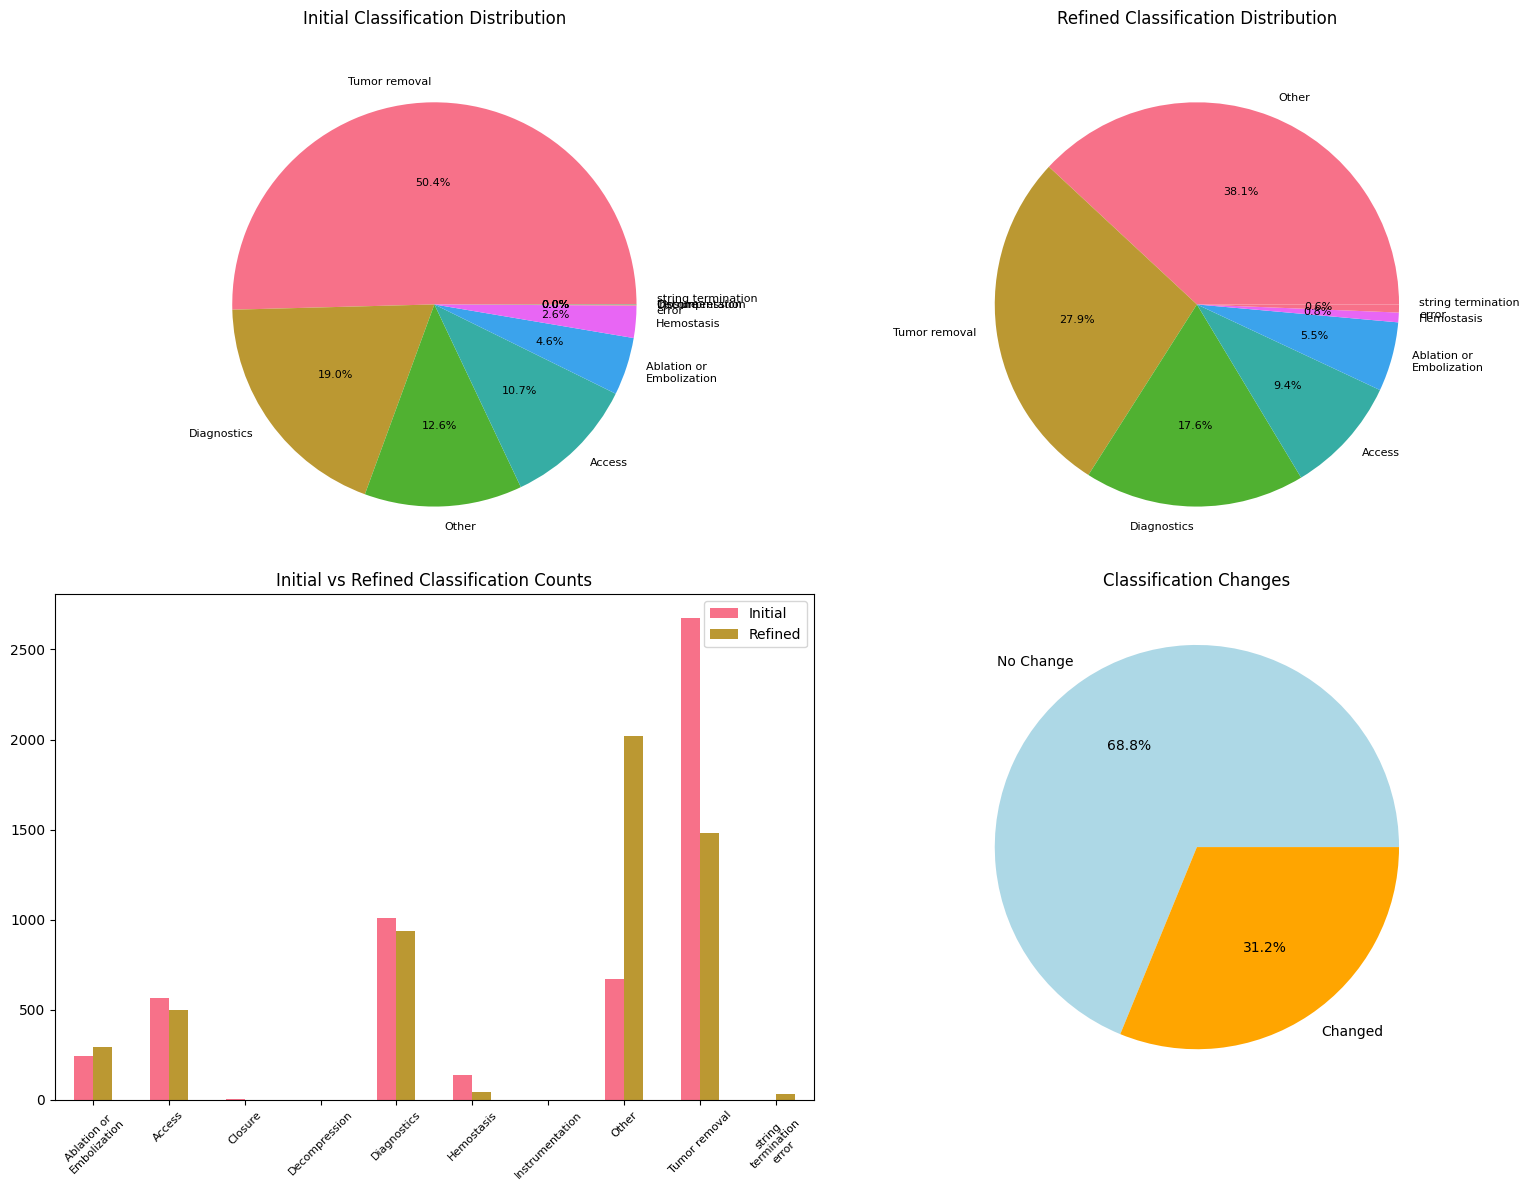


📊 CLASSIFICATION SUMMARY:
Total procedures: 5,300
Changed classifications: 1,653 (31.2%)
Initial classes: 10
Refined classes: 7


In [52]:
plot_classification_distributions(
    df, 
    init_class_col='INITIAL_CLASSIFICATION_RESULT', refined_class_col='REFINEMENT_RESULT'
)

### Examples for each class

In [27]:
def show_procedure_examples(df, data_col, init_class_col, refined_class_col, n_common=5, n_random=3):
    """Show most common and random examples for each classification"""
    
    print("="*80)
    print("PROCEDURE EXAMPLES BY CLASSIFICATION")
    print("="*80)
    
    # For refined classifications
    for class_name in df[refined_class_col].unique():
        class_procedures = df[df[refined_class_col] == class_name][data_col]

        print(f"\n📋 CLASS: {class_name}")
        print(f"Total procedures: {len(class_procedures)}")
        print("-" * 50)
        
        # Most common procedures
        most_common = class_procedures.value_counts().head(n_common)
        print(f"🔥 Most Common Procedures:")
        for i, (procedure, count) in enumerate(most_common.items(), 1):
            print(f"  {i}. {procedure} ({count})")
        
        # Random samples
        random_samples = class_procedures.drop_duplicates().sample(min(n_random, len(class_procedures.unique())))
        print(f"\n🎲 Random Examples:")
        for i, procedure in enumerate(random_samples, 1):
            print(f"  {i}. {procedure}")
        
        print()

In [28]:
show_procedure_examples(
    df,
    data_col='DATA',
    init_class_col='INITIAL_CLASSIFICATION_RESULT', refined_class_col='REFINEMENT_RESULT',
    n_common=5, n_random=5
)

PROCEDURE EXAMPLES BY CLASSIFICATION

📋 CLASS: Diagnostics
Total procedures: 935
--------------------------------------------------
🔥 Most Common Procedures:
  1. TRANSJUGULAR LIVER BIOPSY (2)
  2. FIDUCIAL SEED PLACEMENT (2)
  3. ABSCESS/COLLECTION ASPIRATE CHEST (2)
  4. EPIDURAL ASPIRATION (2)
  5. LUMBAR MYELOGRAM (2)

🎲 Random Examples:
  1. THORACOTOMY MAJOR W/ EXPLORATION/BIOPSY < 8 Y.O.
  2. BIOPSY, BONE
  3. BIOPSY SOFT TISSUE LEG/ANKLE SUPERFICIAL
  4. BIOPSY/EXCISION CERVICAL LYMPH NODE/S DEEP W/ SCALENE FAT PAD
  5. SPINAL CANAL MYELOGRAM


📋 CLASS: Tumor removal
Total procedures: 1479
--------------------------------------------------
🔥 Most Common Procedures:
  1. EXCISION, FACIAL BONE (1)
  2. COLONOSCOPY W/ REMOVAL TUMOR/POLYP/LESION BY SNARE TECHNIQUE (1)
  3. COLONOSCOPY W/ REMOVAL TUMOR/POLYP/LESION BY BIOPSY FORCEPS/BIPOLAR CAUTERY (1)
  4. CRANIOTOMY, WITH SUPRATENTORIAL NEOPLASM EXCISION (1)
  5. CERVICAL LYMPHADENECTOMY (MODIFIED RADICAL NECK) (1)

🎲 Random Examp

### Reclassification between models

In [34]:
def analyze_classification_changes(df, data_col, init_class_col, refined_class_col):
    """Analyze and visualize classification changes"""
    
    # Create change summary
    changes_df = df[df[init_class_col] != df[refined_class_col]].copy()

    if len(changes_df) == 0:
        print("No classification changes found!")
        return
    
    print("="*80)
    print("CLASSIFICATION CHANGES ANALYSIS")
    print("="*80)
    
    # Change patterns
    change_patterns = changes_df.groupby([init_class_col, refined_class_col]).size().reset_index(name='count')
    change_patterns = change_patterns.sort_values('count', ascending=False)
    
    print(f"\n📊 Change Patterns ({len(changes_df)} total changes):")
    print("-" * 50)
    for _, row in change_patterns.head(10).iterrows():
        print(f"  {row[init_class_col]} → {row[refined_class_col]}: {row['count']} cases")

    # Visualize change matrix
    pivot_changes = change_patterns.pivot(index=init_class_col, 
                                        columns=refined_class_col, 
                                        values='count').fillna(0)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_changes, annot=True, fmt='g', cmap='YlOrRd', square=True)
    plt.title('Classification Change Matrix\n(Initial → Refined)')
    plt.xlabel('Refined Classification')
    plt.ylabel('Initial Classification')
    plt.tight_layout()
    plt.show()
    
    # Show specific examples of changes
    print(f"\n📝 Examples of Classification Changes:")
    print("-" * 50)
    for _, row in change_patterns.head(5).iterrows():
        initial = row[init_class_col]
        refined = row[refined_class_col]
        examples = changes_df[
            (changes_df[init_class_col] == initial) & 
            (changes_df[refined_class_col] == refined)
        ][data_col].head(3)

        print(f"\n{initial} → {refined}:")
        for i, example in enumerate(examples, 1):
            print(f"  {i}. {example}")

CLASSIFICATION CHANGES ANALYSIS

📊 Change Patterns (1653 total changes):
--------------------------------------------------
  Tumor removal → Other: 1054 cases
  Access → Other: 109 cases
  Diagnostics → Other: 93 cases
  Hemostasis → Other: 93 cases
  Tumor removal → Ablation or Embolization: 65 cases
  Tumor removal → Diagnostics: 43 cases
  Tumor removal → Access: 38 cases
  Tumor removal → string termination error: 17 cases
  Diagnostics → Tumor removal: 14 cases
  Ablation or Embolization → Other: 14 cases


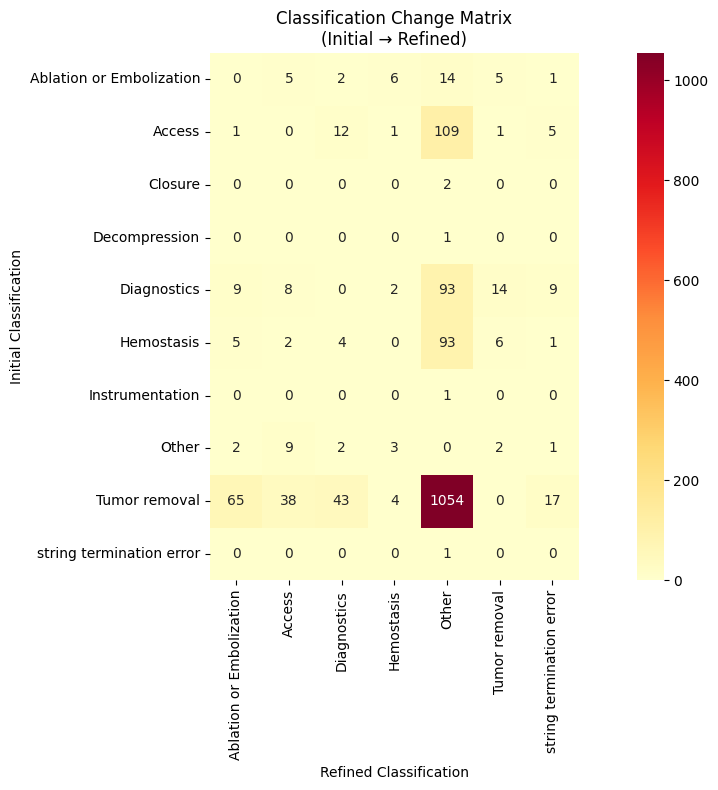


📝 Examples of Classification Changes:
--------------------------------------------------

Tumor removal → Other:
  1. TUNICA VAGINALIS HYDROCELE REPAIR
  2. PERCUTANEOUS SCREW STABILIZATION
  3. IR KYPHOPLASTY

Access → Other:
  1. VASCULAR STENT, VEIN
  2. IR VASCULAR STENT, VEIN
  3. CYSTOSCOPY WITH SIMPLE REMOVAL OF URETERAL STENT FROM URETHRA

Diagnostics → Other:
  1. NERVE BLOCK ANESTHESIA
  2. PLACEMENT OF INTERSTITIAL DEVICE/FIDUCIAL MARKERS/SPACERS FOR RADIATION TX GUIDANCE, TRANSRECTAL APPROACH
  3. IR PLEUREX ASPIRA PLACE CATH

Hemostasis → Other:
  1. IR ABSCESS CONVERT SURGICAL TO IR DRAIN
  2. IR IVC FILTER
  3. IVC FILTER

Tumor removal → Ablation or Embolization:
  1. INTERSTITIAL RADIATION SOURCE APPLICATION COMPLEX
  2. UGI ENDOSCOPY W/ABLATION OF TUMOR/POLYPS
  3. BRONCHOSCOPY DESTRUCTION TUMOR CONTACT CRYOTHERAPY FLEXIBLE


In [35]:
analyze_classification_changes(
    df,
    data_col='DATA',
    init_class_col='INITIAL_CLASSIFICATION_RESULT', refined_class_col='REFINEMENT_RESULT',
)

### Interactive

In [37]:
def create_sankey_diagram(df, init_class_col, refined_class_col):
    """Create interactive Sankey diagram showing classification flow"""
    
    # Prepare data for Sankey
    initial_classes = df[init_class_col].unique()
    refined_classes = df[refined_class_col].unique()
    all_classes = list(set(list(initial_classes) + list(refined_classes)))
    
    # Create mappings
    class_to_idx = {cls: i for i, cls in enumerate(all_classes)}
    
    # Calculate flows
    flows = df.groupby([init_class_col, refined_class_col]).size().reset_index(name='count')

    source = [class_to_idx[cls] for cls in flows[init_class_col]]
    target = [class_to_idx[cls] for cls in flows[refined_class_col]]
    values = flows['count'].tolist()
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_classes,
            color="blue"
        ),
        link=dict(
            source=source,
            target=target,
            value=values
        )
    )])
    
    fig.update_layout(title_text="Classification Flow: Initial → Refined", font_size=10)
    fig.show()